# Setting up our Notebook

In [23]:
# Import the necessary modules 


# Standard Imports
import matplotlib.pyplot as plt
import numpy as np
import string
import math
import random 

# Processing
from sklearn.decomposition import PCA

# Neural Nets
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow as tf2
from tensorflow import keras
print('Tensorflow Version',tf.__version__)

# NLP
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from gensim.models import Doc2Vec
from collections import namedtuple # For Doc2Vec

# PDF manipulation
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import StringIO

# Other
import collections
from scipy import spatial

Tensorflow Version 2.9.1


In [24]:
# Opening our file

# Note: We can open it with read(), readline(), or readline()
# See: https://www.pythontutorial.net/python-basics/python-read-text-file/

with open("Data/Orbit.txt", "r", encoding="unicode_escape") as doc:
    text = doc.read()

In [25]:
print(text[0:133])
book_text = text[133:]

Christopher Clark
565 Cleve Cole Rd.
(972) 854-9024
Christopher.w.clark89@gmail.com



13,900 words











ORBIT

by Christopher



# Mathematics of Skip-Gram

## Vector Representations

In the skip-gram model, we are going to train a neural-network model to predict words. However, we aren't going to use the model for this, but to get the *weights* of the models, which will be vector respresentations of the words in relation to the vocabulary $V$. 

So, our *fake* problem is, given a *context* or *inside* word and a window of size $n$, to predict the *outside* words a distance of $j \in {-n,...-1,1,...n}$ away from the inside word. Now, each word $w \in V$ will recieve two vector representations. The first, $\mathbf{v}$, will be used when the word in question is acting as the inside word, and $\mathbf{u}$ when it is acting as the outside word. Then, we have two sets of weights:

$$ \mathbf{V} = [ \mathbf{v}_{w_1},...,\mathbf{v}_{w_|V|} ]^T $$
$$\mathbf{U} = [ \mathbf{u}_{w_1},...,\mathbf{u}_{w_|V|} ]^T $$

Graphically, this looks like:

<img src="Graphics/CBoW and Skip-Gram Design.png" width="600" height="600" />

## Defining $p(w_O|w_I, \mathbf{V,U})$

Now:

$$p(w_O|w_I, \mathbf{V,U}) = \frac{e^{\mathbf{u}_{w_O}^T \mathbf{v}_{w_I}}} {\sum_{w \in V} e^{\mathbf{u}_w ^T \mathbf{v}_{w_I}}}$$

## Loss function

We will now consider a single sentence $\mathbf{w}$ of length $T$. In this case, $w_{t+j}$ is the outside word and $w_t$ the inside one. We will use the log-probability as the function of interest to remove the exponentials.

The loss function we will implement over this sentence is:

$$ \mathcal{L}(\mathbf{w,V,U}) = -\frac{1}{T} \sum_{t=1}^T \sum_{-n \leq j \leq n, j\neq 0} \log p(w_{t+j}|w_t, \mathbf{V,U})$$

However, we note that, unfortunately, this becomes difficult as $V$ grows, so in practice, we will implement *Heirarchical Softmax* or *Negative Sampling* to aid in our training. 

So, we will train a neural network to predict words in the manner described above, and then we will take the vector respresentations as our actual interest. In this case, they will be $\mathbf{V}$. This is represented by:

<img src="Graphics/Mathematical Skip-Gram Model.png" width="300" height="300" />

In the above graphic, $W=\mathbf{V}$ and $W'=\mathbf{U}$. Then, $N$ is the size of the hidden layer. Usually, we take the $\mathbf{V}$ vectors as the representations for other uses.

## Alternative Loss Function: Heirarchical Softmax

In heirachical softmax, we replace $p(w_O|w_I, \mathbf{V,U})$ with:

$$ p(w_O|w_I, \mathbf{V,U}) = \prod_{j=1}^{L(w_O)-1} \sigma \left( [\![n(w_O,j+1)=ch(n(w_O,j)) ]\!] \mathbf{u}_{n(w_O,j)}^T \mathbf{v}_{w_I} \right) $$

This model uses a binary tree representation of the output layer with the $V$ words as its leaves and, for each node, explicitly represents the relative probabilities of its child nodes. These define a random walk that assigns probabilities to words. So, $n(w,j)$ is the $j$-th node from the root to word $w$, $L(w)$ is the length of this path, so $n(w,1)$ is the root and $n(w,L(w))=w$. Then, for any inner node $n$, $ch(n)$ is an arbitrary fixed child of $n$ and $[\![x]\!]$  is $1$ if $x$ is true and $-1$ otherwise. Finally, $\sigma (x)$ is the sigmoid function. 

## Alternative Loss Function: Negative Sampling

For negative sampling, we replace $\log p(w_O|w_I, \mathbf{V,U})$ by:

$$ \log p(w_O|w_I, \mathbf{V,U}) \approx \log \sigma(\mathbf{u}_{w_O} ^T \mathbf{v}_{w_I}) +\sum_{i=1}^K 
\mathbb{E}_{w_i \sim P_n (w)} [\log \sigma(-\mathbf{u}_{w_i} ^T \mathbf{v}_{w_I})] 
$$

# Mathematics of Continuous Bag of Words

In the *Continuous Bag of Words* (CBoW) model, we are trying to do the opposite of the skip-gram model, namely, trying to take outside words and predict and inside one. The general structure will be the same, but we are now using several outside vectors in conjunction with a single inside one to generate our prediction. Thus, our fake task is to train for:

$$p(w_I|w_{O_1}, ..., w_{O_2n})$$

We note that there are at most $2n$ possible words on either side. Thus, our probability function becomes:

$$p(w_I|w_{O_1}, ..., w_{O_2n}) \frac{e^{\frac{1}{2n} \mathbf{u}_{w_I}^T \mathbf{u}_{w_I}^T (\mathbf{v}_{w_{O_1}}, ... , \mathbf{v}_{w_{O_2n}})}} {\sum_{w \in V} e^{\mathbf{u}_w ^T \mathbf{u}_{w_I}^T (\mathbf{v}_{w_{O_1}}, ... , \mathbf{v}_{w_{O_2n}})}}$$

## Loss function

For brevity, we will say:

$$ \{w_{O_1}, ..., w_{O_2n}\} = W_o$$

Our loss function for CBoW is:

$$ \mathcal{L}(\mathbf{w,V,U}) = -\frac{1}{T} \sum_{t=1}^T  \log p(w_t|W_O, \mathbf{V,U})$$

Graphically, we have:
    
<img src="Graphics/Mathematical CBoW Model.png" width="300" height="300" />

And the matrices represent the same thing as above, but we must be aware of the different interpretations of $\mathbf{V}$ and $\mathbf{U}$.

We note that, as in the skip-gram, we will use the two simplifying loss functions described above.

# Doc2Vec

*Doc2Vec* proceeds in much the same was as Word2Vec, except, instead of just training for vector representations of words, it also trains for a document representation.

Graphically, we have:
    
<img src="Graphics/Mathematical Doc2Vec Model.jpg" width="300" height="300" />

# Mathematics of Global Vectors

We will turn to another, similar, model, *Global Vectors*, or *GloVe*. In the above models, we train based on some window of context per sentence, but it might be the case that word-pairs occur several times throughout the corpus. This can carry significant semantic information. Words that occur in some window of context together often might imply a relationship between them, for example. So, we will take our Skip-Gram model and modify it. 

We will denote the set of center or inside vectors for each word, $\mathbf{v}_i$, as $\mathbf{V}$, and the set of outside or context vectors $\mathbf{u}_i$ as $U$.

Now, consider some word w_i and take all the context words where $w_i$ is the center. We can take all the indices of those context words and collect them in a multiset, $\mathcal{C}_i$, where the same element can occur multiple times. We can then ask for the multiplicity of some element (and integer) in $\mathcal{C}_i$, which will be the number of times the word indexed by that integer appears as a context word in which word $w_i$ is the center word. We denote this with $x_{ij}$. Again, this is the number of co-occurrences of word $w_j$ as a context word with word $w_i$ as the center in the entire corpus.

Then, the loss function we wish to minimize is:

$$ \mathcal{L}(\mathbf{V}, \mathbf{U}, \mathbf{b}, \mathbf{c}) = 
\sum_{i,j \in \{1,2,...,|V|\}}^{|V|} h(x_{ij}) (\mathbf{u}_j^T \mathbf{v}_i +b_i +c_j- \log x_{ij})^2  $$

In the above, $\mathbf{b}$ is a vector of length $|V|$ of center-word biases and $\mathbf{c}$ is a vector of length $|V|$ of context-word biases and commonly:

$$ h(x_{ij})= \begin{cases}
  \frac{x_{ij}}{c}, x_{ij} < c \\
  1, \text{otherwise}
\end{cases} $$

# Parameters and functions

In [26]:
#Parameters 
np.random.seed(2018)
epochs = 200
batch_size = 32
skip_gram_window_size = 2
cbow_window_size = 8
learning_rate = 1e-4
embedding_dim = 300
stop_words = stopwords.words('english')
punctuation = set(string.punctuation)

In [27]:
max_pages = 20
pdf_file = 'economics_textbook.pdf'

In [28]:
def remove_non_ascii(text):
    return ''.join([word for word in text if ord(word) < 128])

In [29]:
def cosine_similarity(v1, v2):
    return np.dot(v1, v2)/float(np.linalg.norm(v1)*np.linalg.norm(v2))

In [30]:
def euclidean_norm(vector):
    return np.sqrt(np.sum([_vector**2 for _vector in vector]))

In [31]:
def load_data(raw_text=False, pdf_file=pdf_file, max_pages=max_pages, directory='Data/'+pdf_file):
    return_string = StringIO()
    device = TextConverter(PDFResourceManager(), return_string, codec='utf-8', laparams=LAParams())
    interpreter = PDFPageInterpreter(PDFResourceManager(), device=device)
    filepath = open(directory, 'rb')
    for page in PDFPage.get_pages(filepath, set(), maxpages=max_pages, caching=True, check_extractable=True):
        interpreter.process_page(page)
    text_data = return_string.getvalue()
    filepath.close(), device.close(), return_string.close()
    if raw_text == True: return remove_non_ascii(text_data)
    else: text_data = ' '.join([word for word in word_tokenize(remove_non_ascii(text_data)) if word not in stop_words])
    return text_data

In [32]:
def gensim_preprocess_data_pdf(max_pages):
    data = load_data(max_pages=max_pages)
    sentences = sent_tokenize(data)
    tokenized_sentences = list([word_tokenize(sentence) for sentence in sentences])
    for i in range(0, len(tokenized_sentences)):
        tokenized_sentences[i] = [word for word in tokenized_sentences[i] if word not in punctuation]
    return tokenized_sentences

In [33]:
def gensim_preprocess_data(text):
    data = text
    sentences = sent_tokenize(data)
    tokenized_sentences = list([word_tokenize(sentence) for sentence in sentences])
    for i in range(0, len(tokenized_sentences)):
        tokenized_sentences[i] = [word for word in tokenized_sentences[i] if word not in punctuation]
    return tokenized_sentences

In [34]:
def gensim_skip_gram(sentences):
    skip_gram = Word2Vec(sentences=sentences, window=1, min_count=10, sg=1) # Model containing vectors 'wv.vectors',
    # and 'key_to_index' or 'index_to_key'. Note, sg=1 is skip-gram
    word_embedding = skip_gram.wv.vectors # Just the vectors
    return skip_gram, word_embedding

In [35]:
def gensim_cbow(sentences):
    cbow = Word2Vec(sentences=sentences, window=1, min_count=10, sg=0, cbow_mean=0) # Model containing vectors 
    # 'wv.vectors', and 'key_to_index' or 'index_to_key'. Note, sg=0 is CBoW
    word_embedding = cbow.wv.vectors # Just the vectors
    return cbow, word_embedding

# Word2Vec Word Embeddings

## Skip-gram

### PDF

In [36]:
pdf_tokens = gensim_preprocess_data_pdf(max_pages)

In [37]:
pdf_tokens[0:2]

[['This',
  'text',
  'adapted',
  'The',
  'Saylor',
  'Foundation',
  'Creative',
  'Commons',
  'Attribution-NonCommercial-ShareAlike',
  '3.0',
  'License',
  'without',
  'attribution',
  'requested',
  'works',
  'original',
  'creator',
  'licensee'],
 ['Saylor',
  'URL',
  'http',
  '//www.saylor.org/books',
  'Saylor.org',
  '1',
  'Preface',
  'We',
  'written',
  'fundamentally',
  'different',
  'text',
  'principles',
  'economics',
  'based',
  'two',
  'premises',
  '1']]

In [38]:
skip_gram, word_embedding = gensim_skip_gram(pdf_tokens)

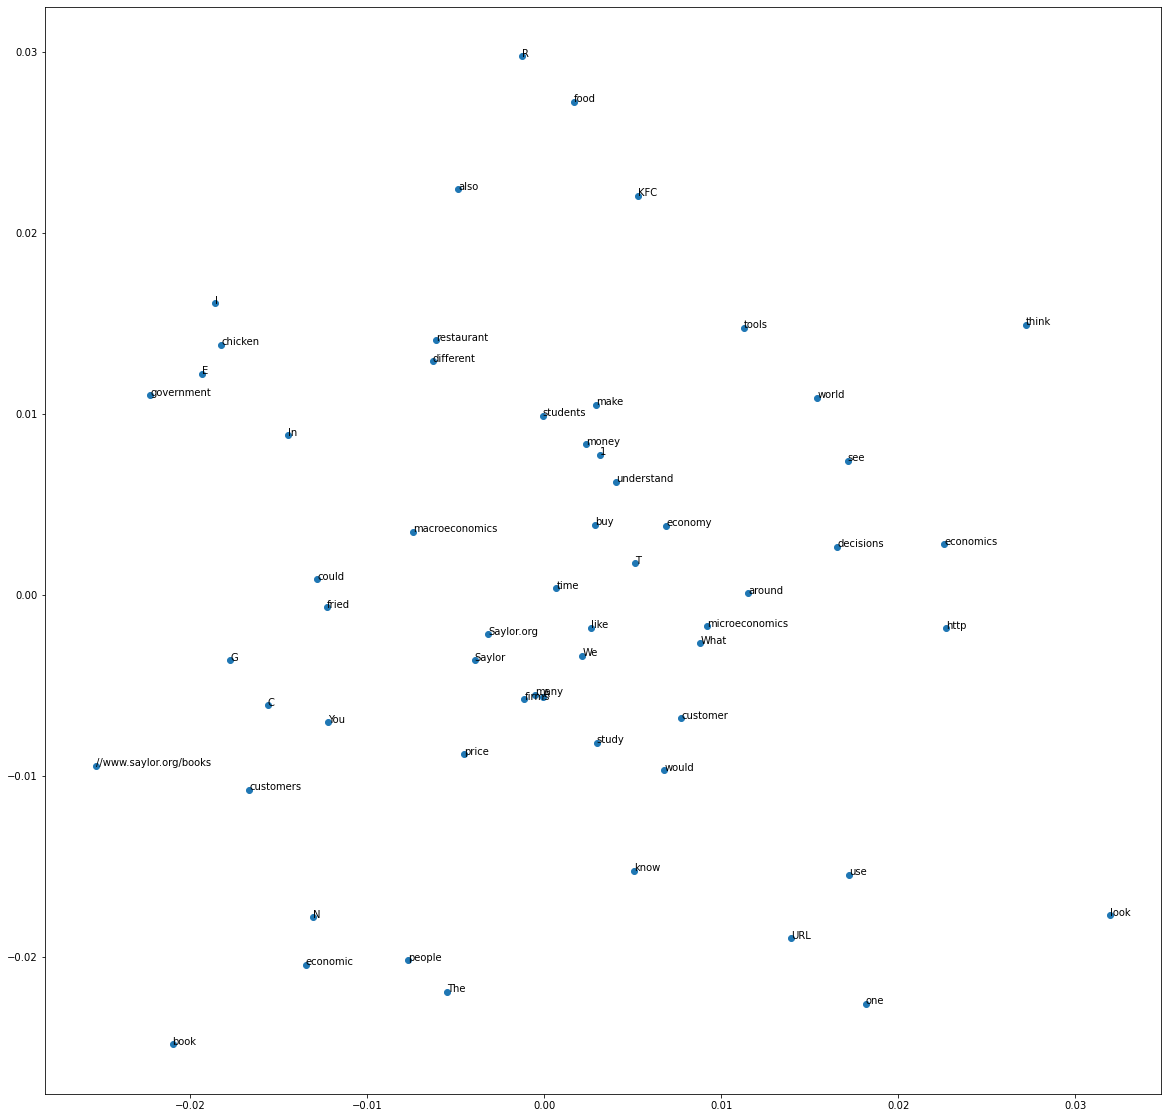

In [39]:
# Vector Visualizations using PCA

plt.figure(figsize=(20,20))
pca = PCA(n_components=2)
pca_word_embedding = pca.fit_transform(word_embedding)
    
#Plotting results from trained word embedding
plt.scatter(pca_word_embedding[:, 0], pca_word_embedding[:, 1])
word_list = list(skip_gram.wv.key_to_index.keys()) # Gets the key_index dict from skip_gram model, then only the keys
for i, word in enumerate(word_list):
    plt.annotate(word, xy=(pca_word_embedding[i, 0], pca_word_embedding[i, 1])) 

In [40]:
# Printing Cosine Similarities of a few words

for i in range(1, len(word_list)- 1):
    print(str('Cosine distance for %s  and %s' + 
            '\n ' + 
            str(cosine_similarity(word_embedding[i, :], word_embedding[i-1, :])))%(word_list[i], word_list[i-1]))

Cosine distance for The  and economics
 0.0034245989322314024
Cosine distance for KFC  and The
 -0.013031619904570118
Cosine distance for You  and KFC
 -0.008274331545010397
Cosine distance for E  and You
 -0.029278204339014298
Cosine distance for A  and E
 0.17445764018234725
Cosine distance for also  and A
 0.03824598517262687
Cosine distance for We  and also
 0.016302666762973456
Cosine distance for world  and We
 -0.13416633383749552
Cosine distance for http  and world
 0.04855531381081187
Cosine distance for study  and http
 0.027023910878410863
Cosine distance for Saylor  and study
 0.12058350092055259
Cosine distance for Saylor.org  and Saylor
 -0.005705777477712968
Cosine distance for //www.saylor.org/books  and Saylor.org
 -0.05181461524906891
Cosine distance for N  and //www.saylor.org/books
 0.07814081586042487
Cosine distance for URL  and N
 -0.08099323167617486
Cosine distance for see  and URL
 0.07395617552298028
Cosine distance for economic  and see
 -0.13033502093675708

### Text from the book

In [41]:
book_tokens = gensim_preprocess_data(book_text)

In [42]:
book_tokens[0:5]

[['Appearance',
  'Message',
  'Iteration',
  '3561',
  'Destination',
  'Kepler-1638b',
  'orbiting',
  'Kepler-1638',
  'type',
  'G4V',
  'star'],
 ['Estimated',
  'arrival',
  'Standard',
  'Earth',
  'Year',
  '4543',
  'Origin',
  'Earth',
  'orbiting',
  'Sol',
  'type',
  'G2V',
  'star'],
 ['Emission',
  'Date',
  'August',
  '27th',
  'Standard',
  'Earth',
  'Year',
  '2051',
  'Platform',
  'SETI',
  'Long-Range',
  'Radio',
  'Broadcasting',
  'Antennae',
  'aboard',
  'the',
  'Mission',
  'Cassandra',
  'Low',
  'Orbit',
  'Satellite',
  'Subject',
  'You',
  'Are',
  'Not',
  'Alone'],
 ['You',
  'Are',
  'In',
  'Danger',
  'This',
  'is',
  'NASA',
  'Mission',
  'Specialist',
  'Dr.',
  'Alexander',
  'Demopoulos',
  'Michaelson',
  'the',
  'last',
  'remaining',
  'member',
  'of',
  'Mission',
  'Cassandra',
  'representing',
  'the',
  'entirety',
  'of',
  'my',
  'civilization',
  'the',
  'civilization',
  'of',
  'Man'],
 ['We',
  'are',
  'lost',
  'but',
  

In [43]:
skip_gram, word_embedding = gensim_skip_gram(book_tokens)

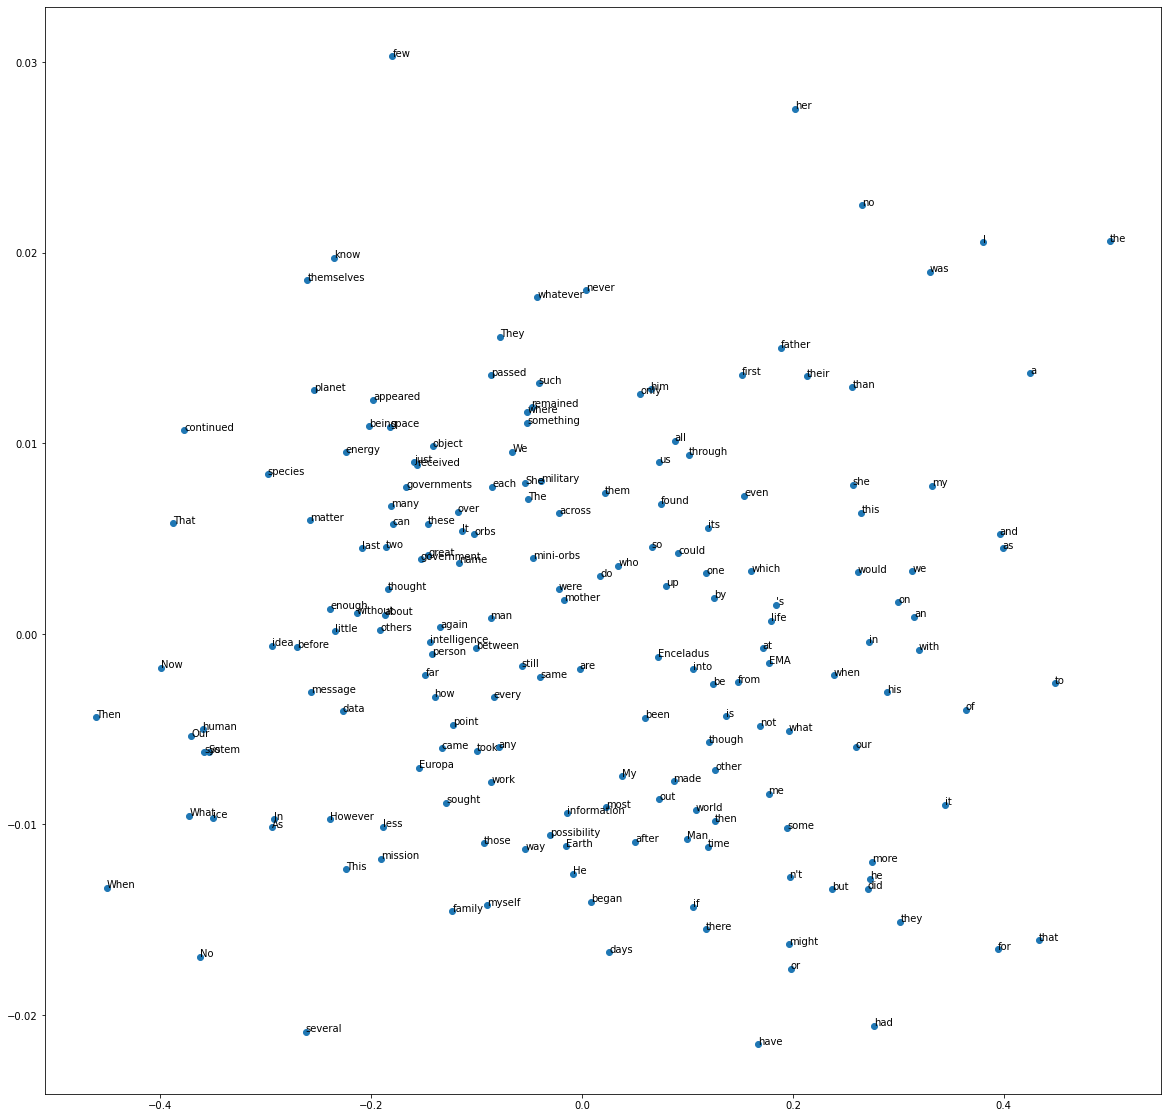

In [44]:
# Vector Visualizations using PCA

plt.figure(figsize=(20,20))
pca = PCA(n_components=2)
pca_word_embedding = pca.fit_transform(word_embedding)
    
#Plotting results from trained word embedding
plt.scatter(pca_word_embedding[:, 0], pca_word_embedding[:, 1])
word_list = list(skip_gram.wv.key_to_index.keys()) # Gets the key_index dict from skip_gram model, then only the keys
for i, word in enumerate(word_list):
    plt.annotate(word, xy=(pca_word_embedding[i, 0], pca_word_embedding[i, 1])) 

In [45]:
# Printing Cosine Similaritys of a few words
for i in range(1, len(word_list)- 1):
    print(str('Cosine distance for %s  and %s' + 
            '\n ' + 
            str(cosine_similarity(word_embedding[i, :], word_embedding[i-1, :])))%(word_list[i], word_list[i-1]))

Cosine distance for of  and the
 0.9981112735912688
Cosine distance for and  and of
 0.9980067542490256
Cosine distance for to  and and
 0.9980373281329971
Cosine distance for that  and to
 0.9980680457334747
Cosine distance for a  and that
 0.998166617453567
Cosine distance for in  and a
 0.997590785972218
Cosine distance for it  and in
 0.9977365162743389
Cosine distance for I  and it
 0.9976244722621028
Cosine distance for was  and I
 0.9979219919206687
Cosine distance for with  and was
 0.9977981231920556
Cosine distance for we  and with
 0.9980263535449025
Cosine distance for on  and we
 0.9975233182374684
Cosine distance for had  and on
 0.997309020547016
Cosine distance for our  and had
 0.9974416916039135
Cosine distance for as  and our
 0.9972217024686963
Cosine distance for The  and as
 0.9965559395537636
Cosine distance for for  and The
 0.9957932172669305
Cosine distance for my  and for
 0.99786562931566
Cosine distance for EMA  and my
 0.9971039370719916
Cosine distance fo

## CBoW

### PDF

In [46]:
pdf_tokens = gensim_preprocess_data_pdf(max_pages)

In [47]:
pdf_tokens[0:5]

[['This',
  'text',
  'adapted',
  'The',
  'Saylor',
  'Foundation',
  'Creative',
  'Commons',
  'Attribution-NonCommercial-ShareAlike',
  '3.0',
  'License',
  'without',
  'attribution',
  'requested',
  'works',
  'original',
  'creator',
  'licensee'],
 ['Saylor',
  'URL',
  'http',
  '//www.saylor.org/books',
  'Saylor.org',
  '1',
  'Preface',
  'We',
  'written',
  'fundamentally',
  'different',
  'text',
  'principles',
  'economics',
  'based',
  'two',
  'premises',
  '1'],
 ['Students', 'motivated', 'study', 'economics', 'see', 'relates', 'lives'],
 ['2'],
 ['Students',
  'learn',
  'best',
  'inductive',
  'approach',
  'first',
  'confronted',
  'question',
  'led',
  'process',
  'answer',
  'question']]

In [48]:
cbow, word_embedding = gensim_cbow(pdf_tokens)

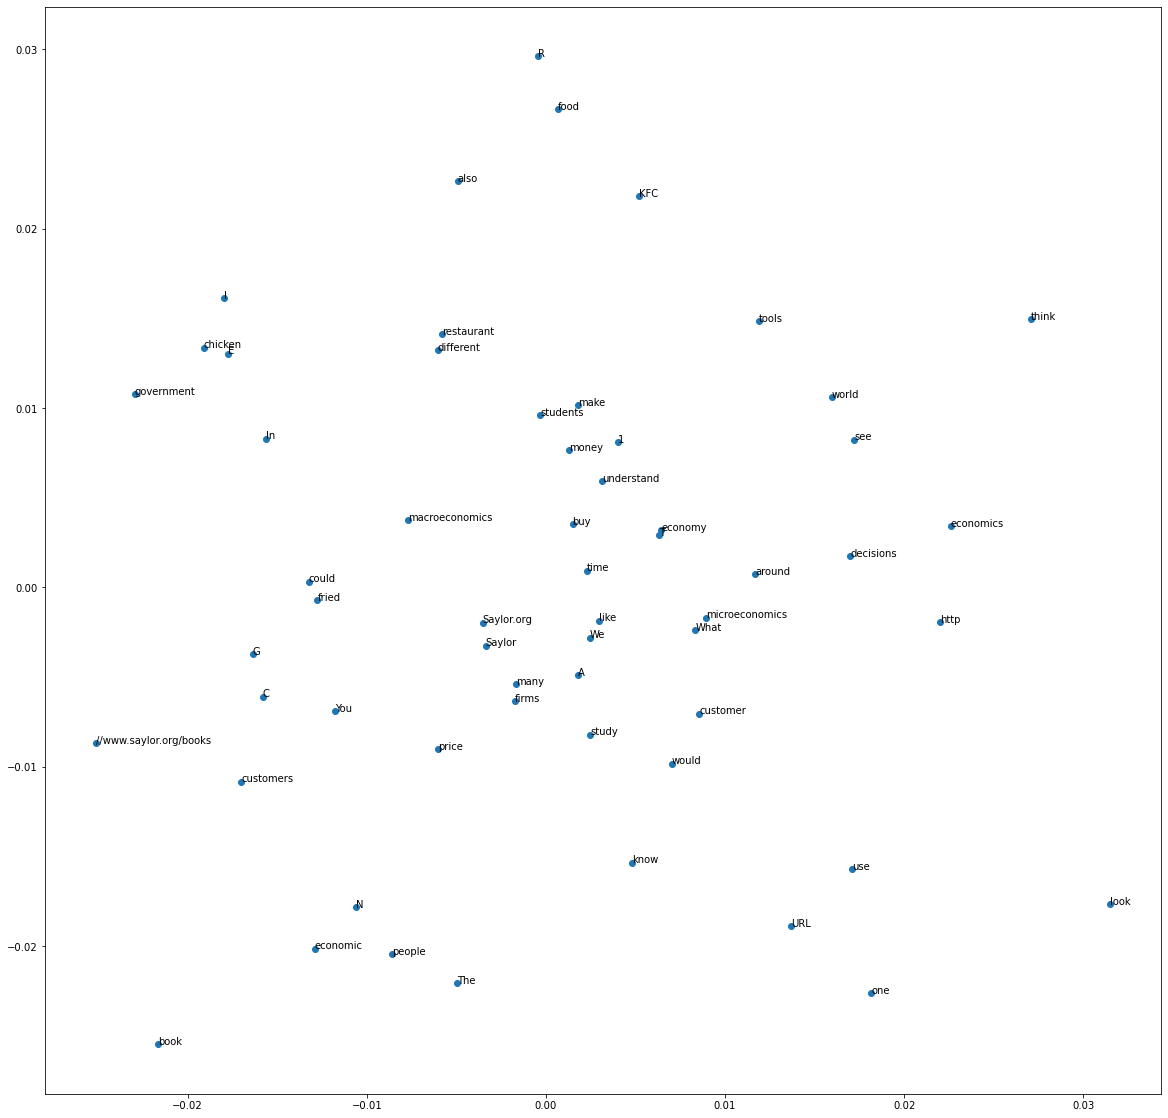

In [49]:
# Vector Visualizations using PCA

plt.figure(figsize=(20,20))
pca = PCA(n_components=2)
pca_word_embedding = pca.fit_transform(word_embedding)
    
#Plotting results from trained word embedding
plt.scatter(pca_word_embedding[:, 0], pca_word_embedding[:, 1])
word_list = list(cbow.wv.key_to_index.keys()) # Gets the key_index dict from cbow model, then only the keys
for i, word in enumerate(word_list):
    plt.annotate(word, xy=(pca_word_embedding[i, 0], pca_word_embedding[i, 1])) 

In [50]:
# Printing Cosine Similarities of a few words

for i in range(1, len(word_list)- 1):
    print(str('Cosine distance for %s  and %s' + 
            '\n ' + 
            str(cosine_similarity(word_embedding[i, :], word_embedding[i-1, :])))%(word_list[i], word_list[i-1]))

Cosine distance for The  and economics
 -0.0031802021041650156
Cosine distance for KFC  and The
 -0.013318712736377693
Cosine distance for You  and KFC
 -0.0036430414271669425
Cosine distance for E  and You
 -0.036826468816743
Cosine distance for A  and E
 0.16216067351382515
Cosine distance for also  and A
 0.032745293640870726
Cosine distance for We  and also
 0.015969380841545294
Cosine distance for world  and We
 -0.13434057320018097
Cosine distance for http  and world
 0.05043120923410801
Cosine distance for study  and http
 0.025680392369822082
Cosine distance for Saylor  and study
 0.12026129880090472
Cosine distance for Saylor.org  and Saylor
 -0.013596443412398847
Cosine distance for //www.saylor.org/books  and Saylor.org
 -0.054923107280417216
Cosine distance for N  and //www.saylor.org/books
 0.055736482366134744
Cosine distance for URL  and N
 -0.08655115518590083
Cosine distance for see  and URL
 0.07246366305802444
Cosine distance for economic  and see
 -0.135319615309549

### Text from the book

In [51]:
book_tokens = gensim_preprocess_data(book_text)

In [52]:
book_tokens[0:5]

[['Appearance',
  'Message',
  'Iteration',
  '3561',
  'Destination',
  'Kepler-1638b',
  'orbiting',
  'Kepler-1638',
  'type',
  'G4V',
  'star'],
 ['Estimated',
  'arrival',
  'Standard',
  'Earth',
  'Year',
  '4543',
  'Origin',
  'Earth',
  'orbiting',
  'Sol',
  'type',
  'G2V',
  'star'],
 ['Emission',
  'Date',
  'August',
  '27th',
  'Standard',
  'Earth',
  'Year',
  '2051',
  'Platform',
  'SETI',
  'Long-Range',
  'Radio',
  'Broadcasting',
  'Antennae',
  'aboard',
  'the',
  'Mission',
  'Cassandra',
  'Low',
  'Orbit',
  'Satellite',
  'Subject',
  'You',
  'Are',
  'Not',
  'Alone'],
 ['You',
  'Are',
  'In',
  'Danger',
  'This',
  'is',
  'NASA',
  'Mission',
  'Specialist',
  'Dr.',
  'Alexander',
  'Demopoulos',
  'Michaelson',
  'the',
  'last',
  'remaining',
  'member',
  'of',
  'Mission',
  'Cassandra',
  'representing',
  'the',
  'entirety',
  'of',
  'my',
  'civilization',
  'the',
  'civilization',
  'of',
  'Man'],
 ['We',
  'are',
  'lost',
  'but',
  

In [53]:
cbow, word_embedding = gensim_cbow(book_tokens)

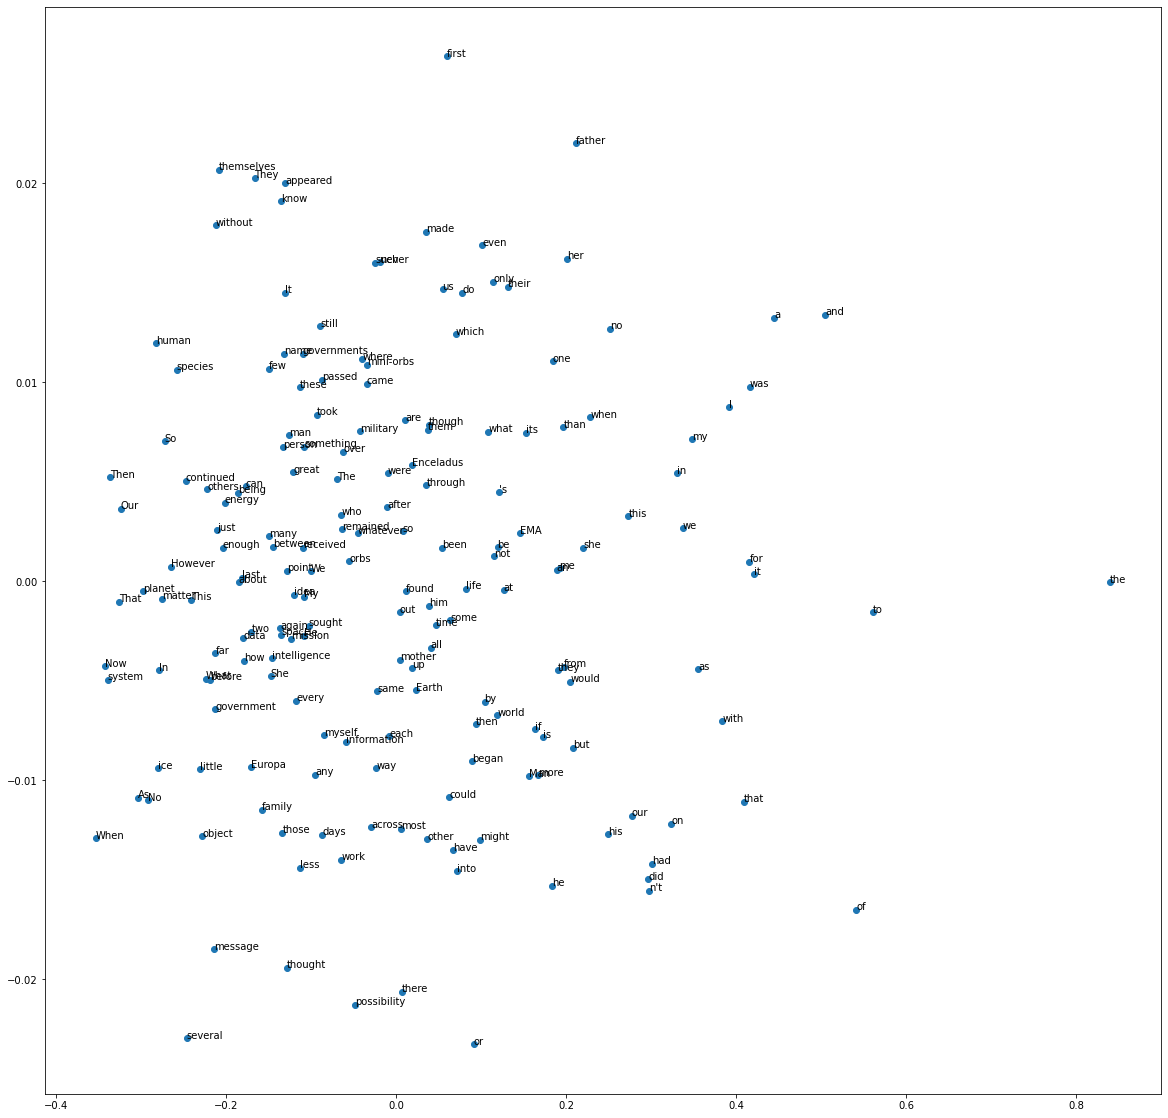

In [54]:
# Vector Visualizations using PCA

plt.figure(figsize=(20,20))
pca = PCA(n_components=2)
pca_word_embedding = pca.fit_transform(word_embedding)
    
#Plotting results from trained word embedding
plt.scatter(pca_word_embedding[:, 0], pca_word_embedding[:, 1])
word_list = list(cbow.wv.key_to_index.keys()) # Gets the key_index dict from skip_gram model, then only the keys
for i, word in enumerate(word_list):
    plt.annotate(word, xy=(pca_word_embedding[i, 0], pca_word_embedding[i, 1])) 

In [55]:
# Printing Cosine Similaritys of a few words
for i in range(1, len(word_list)- 1):
    print(str('Cosine distance for %s  and %s' + 
            '\n ' + 
            str(cosine_similarity(word_embedding[i, :], word_embedding[i-1, :])))%(word_list[i], word_list[i-1]))

Cosine distance for of  and the
 0.9975518691109323
Cosine distance for and  and of
 0.9967166288759975
Cosine distance for to  and and
 0.9967792667514052
Cosine distance for that  and to
 0.996302427970132
Cosine distance for a  and that
 0.9964070840384796
Cosine distance for in  and a
 0.9954309846777277
Cosine distance for it  and in
 0.9956355055042468
Cosine distance for I  and it
 0.995404018725205
Cosine distance for was  and I
 0.9960002191256753
Cosine distance for with  and was
 0.9960322577644662
Cosine distance for we  and with
 0.9961585283376166
Cosine distance for on  and we
 0.9950171446228768
Cosine distance for had  and on
 0.9940985057250755
Cosine distance for our  and had
 0.9942709383883908
Cosine distance for as  and our
 0.9935795188026502
Cosine distance for The  and as
 0.9877630006384678
Cosine distance for for  and The
 0.9858295448735022
Cosine distance for my  and for
 0.9957072258879855
Cosine distance for EMA  and my
 0.9932578772272495
Cosine distance

# Doc2Vec

In [56]:
#Parameters
stop_words = stopwords.words('english')
learning_rate = 1e-4
epochs = 200
max_pages = 300

In [57]:
sample_text1 = '''I love italian food. My favorite items are pizza and pasta,
especially garlic bread. The best italian food I have had has been in New York. 
Little Italy was very fun.'''

sample_text2 = '''My favorite time of italian food is pasta with alfredo sauce. 
It is very creamy but the cheese is the best part. Whenevr I go to an italian 
restaurant, I am always certain to get a plate.'''

In [58]:
def gensim_preprocess_data_d2v(max_pages):
    sentences = namedtuple('sentence', 'words tags')
    token_sentences = sent_tokenize(load_data(max_pages=max_pages))
    documents = []
    for i, text in enumerate(token_sentences):
        words, tags = text.lower().split(), [i]
        documents.append(sentences(words, tags))
    return documents

In [59]:
def train_model(training_example, max_pages=max_pages, epochs=epochs, learning_rate=learning_rate):
    sentences = gensim_preprocess_data_d2v(max_pages=max_pages)
    model = Doc2Vec(alpha=learning_rate, min_alpha=learning_rate/float(3))
    model.build_vocab(sentences)
    model.train(sentences, total_examples=len(sentences), epochs=epochs)
    
    #Showing distance between different documents 
    if training_example == True:
        
        for i in range(1, len(sentences)-1):
            print(str('Document ' + str(sentences[i-1]) + '\n'))
            print(str('Document ' + str(sentences[i]) + '\n'))
            print('Cosine Similarity Between Documents: ' + 
                  '\n' + str(cosine_similarity(model.docvecs[i-1], model.docvecs[i])))
                    
    else:
   
        print('Cosine Similarity Between Sample Texts: ' + 
          '\n' + str(cosine_similarity(model.infer_vector(sample_text1.lower().split()), 
                                        model.infer_vector(sample_text2.lower().split()))))

In [60]:
doc_tokens = gensim_preprocess_data_d2v(max_pages)

In [61]:
doc_tokens[0:5]

[sentence(words=['this', 'text', 'adapted', 'the', 'saylor', 'foundation', 'creative', 'commons', 'attribution-noncommercial-sharealike', '3.0', 'license', 'without', 'attribution', 'requested', 'works', 'original', 'creator', 'licensee', '.'], tags=[0]),
 sentence(words=['saylor', 'url', ':', 'http', ':', '//www.saylor.org/books', 'saylor.org', '1', 'preface', 'we', 'written', 'fundamentally', 'different', 'text', 'principles', 'economics', ',', 'based', 'two', 'premises', ':', '1', '.'], tags=[1]),
 sentence(words=['students', 'motivated', 'study', 'economics', 'see', 'relates', 'lives', '.'], tags=[2]),
 sentence(words=['2', '.'], tags=[3]),
 sentence(words=['students', 'learn', 'best', 'inductive', 'approach', ',', 'first', 'confronted', 'question', 'led', 'process', 'answer', 'question', '.'], tags=[4])]

In [62]:
train_model(False, max_pages=max_pages, epochs=epochs, learning_rate=learning_rate)

Cosine Similarity Between Sample Texts: 
0.8376152196027096


In [63]:
train_model(False, max_pages=max_pages, epochs=epochs, learning_rate=learning_rate)

Cosine Similarity Between Sample Texts: 
0.8329491479429207
